In [31]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn as sl
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from math import sqrt
import xgboost as xgb
from sklearn.linear_model import LinearRegression

In [32]:
df = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/Data Science II/Group Project/Adjusted_Flight_Price_Time_Series.csv')

In [33]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,flight_id
0,120065,Vistara,UK-738,Kolkata,Evening,zero,Night,Delhi,Economy,2.42,1,7368.48,1
1,120065,Vistara,UK-738,Kolkata,Evening,zero,Night,Delhi,Economy,2.42,2,7332.36,1
2,120065,Vistara,UK-738,Kolkata,Evening,zero,Night,Delhi,Economy,2.42,3,7296.24,1
3,120065,Vistara,UK-738,Kolkata,Evening,zero,Night,Delhi,Economy,2.42,4,7260.12,1
4,120065,Vistara,UK-738,Kolkata,Evening,zero,Night,Delhi,Economy,2.42,5,7224.00,1


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        150000 non-null  int64  
 1   airline           150000 non-null  object 
 2   flight            150000 non-null  object 
 3   source_city       150000 non-null  object 
 4   departure_time    150000 non-null  object 
 5   stops             150000 non-null  object 
 6   arrival_time      150000 non-null  object 
 7   destination_city  150000 non-null  object 
 8   class             150000 non-null  object 
 9   duration          150000 non-null  float64
 10  days_left         150000 non-null  int64  
 11  price             150000 non-null  float64
 12  flight_id         150000 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 14.9+ MB


In [35]:
df.describe()

,Unnamed: 0,duration,days_left,price,flight_id
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,149874.466800,12.315088,19.641800,22236.906386,2500.500000
std,86679.966221,7.127591,10.580808,24197.955371,1443.380455
min,106.000000,0.830000,1.000000,1105.000000,1.000000
25%,75096.250000,7.000000,11.000000,5094.182500,1250.750000
50%,149269.500000,11.420000,20.000000,7806.037500,2500.500000
75%,226017.500000,16.170000,27.000000,46130.480000,3750.250000
max,300141.000000,40.420000,49.000000,113522.625000,5000.000000


In [36]:
df = df.drop(columns=['Unnamed: 0'])

In [37]:
df['train_test_mark'] = 'train'  # Default to train

In [53]:
avg_price_over_days = df.groupby('days_left')['price'].mean()


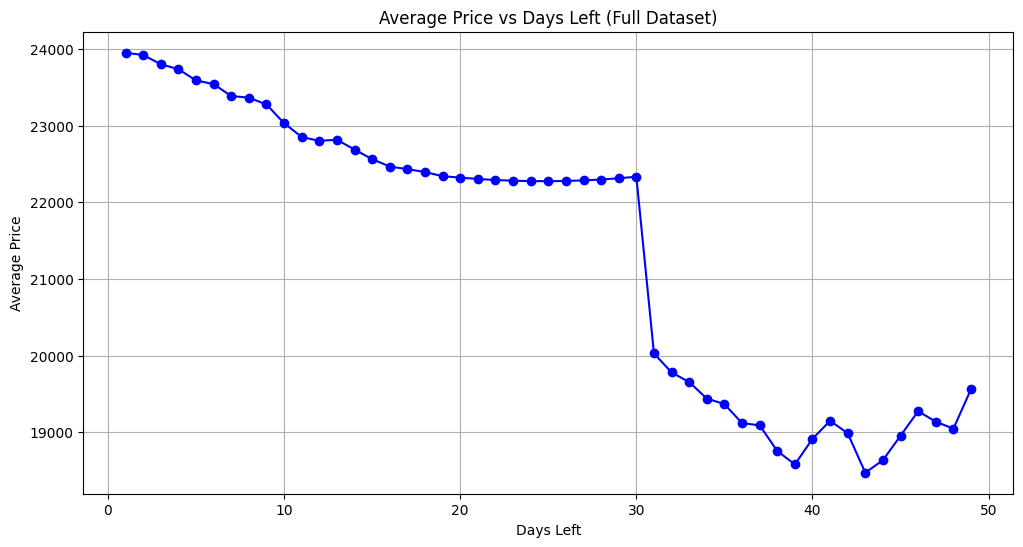

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
avg_price_over_days.plot(kind='line', color='blue', marker='o')
plt.title('Average Price vs Days Left (Full Dataset)')
plt.xlabel('Days Left')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()


In [65]:
sample_flight_id = df['flight_id'].sample(4000).iloc[0]
sample_flight_data = df[df['flight_id'] == sample_flight_id]


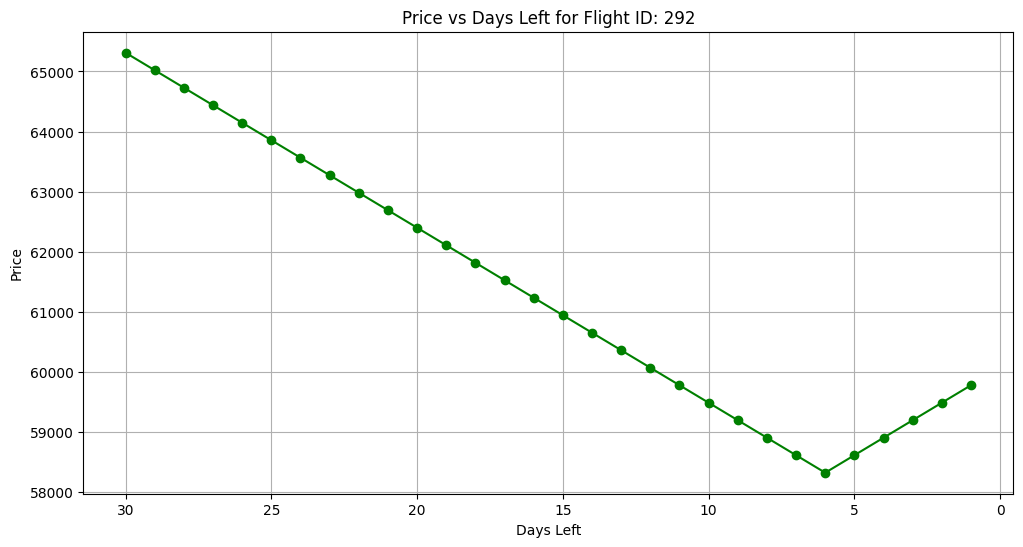

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(sample_flight_data['days_left'], sample_flight_data['price'], marker='o', linestyle='-', color='green')
plt.title(f'Price vs Days Left for Flight ID: {sample_flight_id}')
plt.xlabel('Days Left')
plt.ylabel('Price')
plt.grid(True)
plt.gca().invert_xaxis()  # Inverting the x-axis to show decreasing days left
plt.show()


In [38]:
import numpy as np
for flight_id in df['flight_id'].unique():
    if np.random.rand() > 0.5:
        # Keep as training data
        continue
    else:
        cutoff = np.random.randint(8, 31)  # Random cutoff between 8 and 30 days
        df.loc[(df['flight_id'] == flight_id) & (df['days_left'] < cutoff), 'train_test_mark'] = 'test'


In [39]:
train_df = df[df['train_test_mark'] == 'train'].drop(columns=['train_test_mark'])
test_df = df[df['train_test_mark'] == 'test'].drop(columns=['train_test_mark'])


In [40]:
train_df['flight_id']

0            1
1            1
2            1
3            1
4            1
          ... 
149995    5000
149996    5000
149997    5000
149998    5000
149999    5000
Name: flight_id, Length: 115976, dtype: int64

In [41]:
X_train = train_df.drop(['price'], axis=1)
y_train = train_df['price']

X_test = test_df.drop(['price'], axis=1)
y_test = test_df['price']

Preprocessing building model and Pipeline 

In [42]:
numeric_features = ['duration', 'days_left']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [43]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline to the training data
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'RMSE: {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 48188737.23975782
RMSE: 6941.810804088355
Mean Absolute Error (MAE): 4814.441288069141
R2 Score: 0.922435753324859


In [44]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)

Fit the model(pipeline) on the training data

In [45]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison_df)

           Actual     Predicted
150      5267.845   5619.173500
151      5242.640   5610.086000
152      5217.435   5607.497500
153      5192.230   5611.778000
154      5167.025   5609.189500
...           ...           ...
149887  55685.655  58587.583500
149888  55424.220  58561.440000
149889  55162.785  58195.431000
149890  54901.350  57515.700000
149891  54639.915  57064.724625

[34024 rows x 2 columns]


In [46]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'RMSE: {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R2 Score: {r2}')


Mean Squared Error: 11795970.853527859
RMSE: 3434.5262924496383
Mean Absolute Error (MAE): 1797.2007532446455
R2 Score: 0.9810132897132458


In [47]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price', 'flight_id', 'train_test_mark'],
      dtype='object')

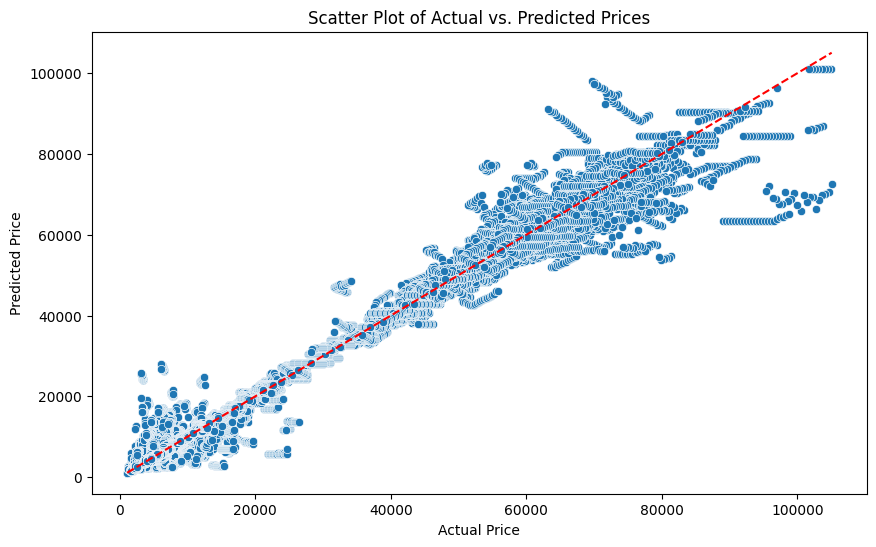

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot of Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Scatter Plot of Actual vs. Predicted Prices')
plt.show()

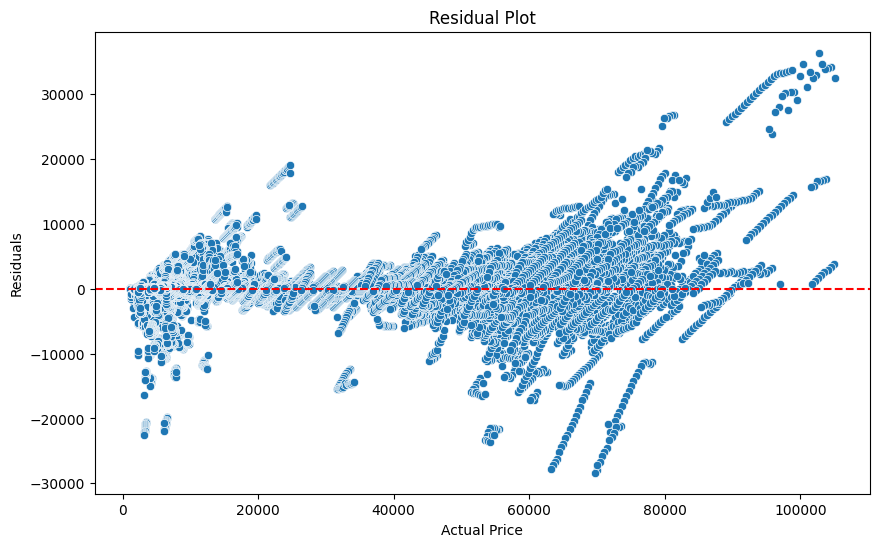

In [49]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

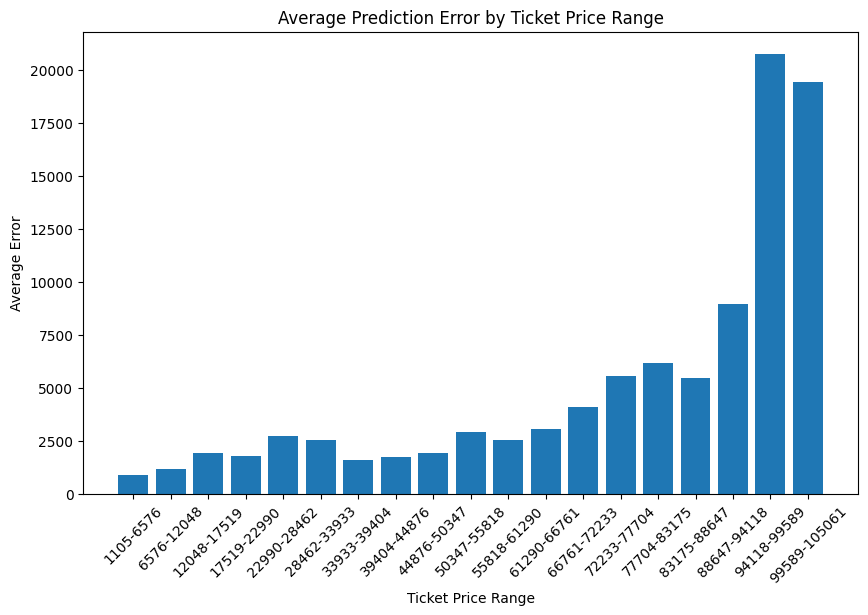

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of bins
num_bins = 20

# Create bins for the ticket prices
bins = np.linspace(y_test.min(), y_test.max(), num_bins)
bin_indices = np.digitize(y_test, bins)

# Calculate average error per bin
bin_avg_error = [np.mean(abs(y_test[bin_indices == i] - y_pred[bin_indices == i])) for i in range(1, len(bins))]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(bins)), bin_avg_error, align='center')
plt.xticks(range(1, len(bins)), [(f'{bins[i]:.0f}-{bins[i+1]:.0f}') for i in range(num_bins-1)], rotation=45)
plt.xlabel('Ticket Price Range')
plt.ylabel('Average Error')
plt.title('Average Prediction Error by Ticket Price Range')
plt.show()


In [51]:
df.describe(include='all')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,flight_id,train_test_mark
count,150000,150000,150000,150000,150000,150000,150000,150000,150000.000000,150000.000000,150000.000000,150000.000000,150000
unique,6,930,6,6,3,6,6,2,NaN,NaN,NaN,NaN,2
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN,NaN,train
freq,63960,1590,30630,34710,126150,45390,29430,103470,NaN,NaN,NaN,NaN,115976
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.315088,19.641800,22236.906386,2500.500000,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.127591,10.580808,24197.955371,1443.380455,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000,1.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,11.000000,5094.182500,1250.750000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.420000,20.000000,7806.037500,2500.500000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,27.000000,46130.480000,3750.250000,NaN


In [52]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

mean_cv_score = np.mean(cv_scores)

mean_cv_score = abs(mean_cv_score)


NameError: name 'pipeline' is not defined

In [ ]:
print(mean_cv_score)

3724.464054314204


In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1))
])

from sklearn.model_selection import GridSearchCV

# Define a range of parameters for XGBoost
param_grid = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7, 10],
    # Add more parameters here if needed
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit grid_search to the data
grid_search.fit(X_train, y_train)

# Best parameters and MAE
best_parameters = grid_search.best_params_
best_mae = abs(grid_search.best_score_)

print("Best Parameters:", best_parameters)
print("Best MAE:", best_mae)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 20, 'regressor__n_estimators': 150}
Best MAE: 974.0678120197081


In [ ]:

optimized_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_parameters['regressor__n_estimators'],
    learning_rate=best_parameters['regressor__learning_rate'],
    max_depth=best_parameters['regressor__max_depth'],
    random_state=42,
    n_jobs=-1
)

optimized_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', optimized_regressor)
])

cv_scores = cross_val_score(optimized_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

mean_cv_score = np.mean(cv_scores)

mean_cv_score = abs(mean_cv_score)

print("Average CV MAE with Optimized Model:", mean_cv_score)


Average CV MAE with Optimized Model: 3638.880448976117


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'RMSE: {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 11729744.91540011
RMSE: 3424.8715180864974
Mean Absolute Error (MAE): 1962.8861618335573
R2 Score: 0.9772451051823939


In [ ]:
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    # Add more parameters here if needed
}

# Create a GridSearchCV object
grid_search_rf = GridSearchCV(pipeline, param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit grid_search to the data
grid_search_rf.fit(X_train, y_train)

# Find the best parameters and the corresponding MAE
best_params_rf = grid_search_rf.best_params_
best_mae_rf = abs(grid_search_rf.best_score_)

print("Best Parameters for RandomForest:", best_params_rf)
print("Best MAE for RandomForest:", best_mae_rf)

In [ ]:
feature_names = numeric_features + \
    list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features))

# Retrieve feature importances from the model
importances = pipeline.named_steps['regressor'].feature_importances_

# Map these importances to the feature names
feature_importances = dict(zip(feature_names, importances))

# Find the importance of 'days_left'
days_left_importance = feature_importances.get('days_left', 0)

print("Importance of days_left feature:", days_left_importance)

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'